
# Stochastic Case

Consider a stochastic version of the reinforcement learning problem posed in Section 1 (figure copie below). Modify the rules so that:

* $\delta(s,a)$ is stochastic: The probability of landing in the intended direction is $0.70$. The probability of landing in one of $n$ unintended legal direction is $\frac{0.30}{n}$.

  * Example 1 : If you are in $s_0$ and action $a$ was $right$, probability of landing in $s_1$ is 0.70, and ending up in $s_3$ u=is 0.3.

  * Example 2: If you are in $s_1$ and $a$ was $down$, probability of landing in $s_4$ is 0.70, ending up in $s_0$ is 0.15 (= 0.3/2), and ending up in $s_2$ is 0.15 (= 0.3/2).

  * Example 3: If you are in $s_4$ and $a$ was $left$, probability of landing in $s_3$ is 0.70, ending up in $s_1$ is 0.1 (= 0.3/3), ending up in $s_5$ is 0.1 (= 0.3/3), and ending up in $s_7$ is 0.1 (= 0.3/3)

* Reward $r(s,a)$ depends on where you landed based on the above. All rewards are 0 unless the resulting state was the goal state $s_8$. For example, if you were in $s_7$ and the action was $a=up$, with 10\% chance you will land in $s_8$, the goal state. In this case $r(s_7, up) = 100$ for that specific run. In a different run, with the same action $up$, if you landed in $s_{10}$, then $r(s_7,up) = 0$. Note that $r(s_7,up)$ can be either 0 or 100, depending on the random outcome.

<figure>
<center>
<img src="https://drive.google.com/uc?export=view&id=1IDUkDGqQ1xSKOT3Wg8SKgAlKsDIdUQUy" height="450px"> &nbsp;&nbsp;&nbsp; &nbsp;<img 
 src="https://drive.google.com/uc?export=view&id=1aGu78DvllvjaDghW7fzNK7uOPeBmebyN" height="450px"> 
<figcaption>Figure 2: Left = same as Figure 1, Right = stochastic behavior </figcaption></center>
</figure>







Delta
     up  down  left  right
s0   -1     3    -1      1
s1   -1     4     0      2
s2   -1     5     1     -1
s3    0     6    -1      4
s4    1     7     3      5
s5    2     8     4     -1
s6    3     9    -1      7
s7    4    10     6      8
s8    8     8     8      8
s9    6    -1    -1     10
s10   7    -1     9     11
s11   8    -1    10     -1


Q: initial
      up  down  left  right
s0  -1.0   0.0  -1.0    0.0
s1  -1.0   0.0   0.0    0.0
s2  -1.0   0.0   0.0   -1.0
s3   0.0   0.0  -1.0    0.0
s4   0.0   0.0   0.0    0.0
s5   0.0   0.0   0.0   -1.0
s6   0.0   0.0  -1.0    0.0
s7   0.0   0.0   0.0    0.0
s8   0.0   0.0   0.0    0.0
s9   0.0  -1.0  -1.0    0.0
s10  0.0  -1.0   0.0    0.0
s11  0.0  -1.0   0.0   -1.0

Final Q table

            up       down       left      right
s0   -1.000000  20.977043  -1.000000  22.811957
s1   -1.000000  35.202728  39.331800  35.770389
s2   -1.000000  50.831781  35.461059  -1.000000
s3   23.769208  41.818916  -1.000000  33.484540
s4   36.

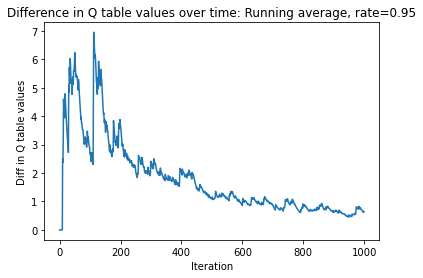

diff in Q reached below 0.01 at iteration = 999


999

In [1]:
#non-deterministic Qlearning algorithm 

import numpy as np
import pandas as pd
import random 
import argparse, sys
import matplotlib.pyplot as plt


mode="notebook" 



class argclass:

  def __init__(self):

    self.alpha = 1.0
    self.gamma = 0.9
    self.epsilon = 0.5
    self.num_iter = 1000
    self.run_avg_rate = 0.95
    self.display_flag = "True"


if (mode=="console"):

  args = parse_args()

elif (mode=="notebook"):

  args = argclass()

else:

  print("Invalid mode: check the config")
  exit()

#--------------------
# find sum of abs difference in the two table values
#--------------------
def df_diff(df1, df2):

  d = df1-df2
  return d.abs().to_numpy().sum() 

#----------------------------------------------------------------------------
#
# Environment set up 
#
#----------------------------------------------------------------------------

#--------------------
# state index 
#--------------------
s_index = ["s0", "s1", "s2", "s3", "s4", "s5", "s6","s7","s8","s9","s10","s11"] 

#--------------------
# state transition table 
#--------------------
delta = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1,-1, -1, 0, 1, 2, 3, 4, 8, 6, 7, 8]),index=s_index),
	  "down" : pd.Series(np.array([ 3, 4, 5,6,7,8,9,10,8,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1, 0, 1,-1, 3, 4, -1,6,8,-1,9,10]),index=s_index),
	  "right": pd.Series(np.array([ 1, 2, -1, 4, 5,-1, 7, 8, 8, 10, 11, -1]),index=s_index)
	}
)


print("\n\nDelta")
print(delta)


#--------------------
# goal state 
#--------------------
goal = 8

#----------------------------------------------------------------------------
#
# Main algorithm 
#
#----------------------------------------------------------------------------

def qlearn(): 
  # extract number of states
  num_states = len(s_index)
  num_actions = 4
  
  # set up (s,a) visit count
  visits = (delta>=0).astype(int)-1
  
  run_avg = 0
  
  #--------------------
  # (1) Initialize Q table to zeros (-1 for invalid actions)
  #
  # - Reuse delta table to filter out invalid moves and set others to zero
  #--------------------
 
  Q=(delta>=0).astype(float)-1 

  old_Q = Q.copy(deep=True) 
  
  print("\n\nQ: initial")
  print(Q)
  n = 0
  #--------------------
  # (2) Main loop
  #--------------------
  
  d = np.zeros(args.num_iter)
  
  for n in range(args.num_iter): 
    old_Q = Q.copy(deep=True)

    #----------
    # 1. s : randomly select state   
    #----------
  
    s = random.randint(0,num_states-1)
  
    while (s==goal): # avoid goal state
      s = random.randint(0,num_states-1)
      
    #----------
    # 2. a : choose action (epsilon greedy policy)
    #----------
  
    if (random.random() < (1-args.epsilon)):
  
      # greedy action:
      a = Q.iloc[s,:].argmax()
  
    else:
  
      # random action
      a = random.randint(0,num_actions-1)
  
      while (delta.iloc[s,a]==-1): # avoid invalid action
        a = random.randint(0,num_actions-1)
  
    #----------
    # 3. train
    #----------
  
    visits.iloc[s,a] = visits.iloc[s,a]+1

    alpha = args.alpha
    gamma = args.gamma
  
    #---------------------------------------
    # 3.1 find next state from (s,a) 
    #---------------------------------------

    #---------------------------------------
    #generating the probability lookup table 
    #---------------------------------------

    probability = pd.DataFrame(columns = ('current_state','action','next_state'))
    for i in range(0,12):
      for j in range(0,4):
        probability = probability.append({'current_state': i, 'action':j, 'next_state':int(delta.iloc[i,j])}, ignore_index=True)


    indexNames = probability[probability['next_state'] == -1 ].index
    probability.drop(indexNames , inplace=True) 

    current_state = probability['current_state'].unique()
    current_state = list(current_state)


    probability_s = pd.DataFrame(columns = ('current_state','action','next_state','probability'))
    for i in current_state:
      action = probability.loc[(probability['current_state'] == i),'action']
      action = list(action)
      for j in action:
        for k in np.array(delta.iloc[i,:]):
          if k>0:
            res = [i for i in np.array(delta.iloc[i,:]) if i>0]
            if k in res:
              if delta.iloc[i,j] == int(k):
                probability_s = probability_s.append({'current_state': i, 'action':j, 'next_state':k, 'probability':0.7}, ignore_index=True)
              else:
                probability_s = probability_s.append({'current_state': i, 'action':j, 'next_state':k, 'probability':0.3/(len(res)-1)}, ignore_index=True)

    df = probability_s 
    #---------------------------------------
    #setting up the reward
    #---------------------------------------

    df['reward'] = [100 if x ==8 else 0 for x in df['next_state']] 

    #---------------------------------------
    #choosing the next state based on probability
    #--------------------------------------- 

    next_s = df.loc[(df['current_state'] == s) & (df['action'] == a), 'next_state']
    next_s = np.array(next_s)
    next_s = next_s.tolist() 
    prob = df.loc[(df['current_state'] == s) & (df['action'] == a), 'probability']
    prob = np.array(prob)
    


    df_1 = pd.DataFrame(data = prob, index = next_s)

    while (True):
        next_state = np.random.choice(next_s) # generate rondom event "a"
        r = random.random()  
        k = float(df_1.loc[next_state,0])
        if (r <= k):  
          # accept event "a"!
          next_state = next_state
          break
        else:
          # reject event "a" and repeat
          continue

    s_next = next_state 

    alpha = 1/(1+visits.iloc[s,a])

    reward = df.loc[(df['current_state'] == s) & (df['action'] == a) & (df['next_state'] == s_next), 'reward']

    #---------------------------------------
    # 3.2 update Q
    #---------------------------------------

    # Equation is: Q(s,a) = (1-alpha) x Q(s,a) + alpha*( r(s,a) + gamma * max_a' Q(s',a') )
    Q.iloc[s,a] = (1.0-alpha)*old_Q.iloc[s,a] + alpha*(int(reward) + gamma*old_Q.iloc[int(s_next),:].max())
  
    #---------------------------------------
    # 3.3 compute running average of the sum of Q(n) minus Q(n-1)
    #---------------------------------------

    d[n] = args.run_avg_rate * run_avg + (1-args.run_avg_rate) * df_diff(Q,old_Q)
    run_avg = d[n]
    old_Q = Q.copy(deep=True)
   

    #---------------------------------------
    # 3.3 print current Q and running average of Q diff.
    #---------------------------------------
    if (args.display_flag == "True"):
  
      print("\nQ : iter="+str(n))
      print(Q)
      print("diff = "+str(d[n]))

    if (n>50  and run_avg < 0.01):
 
        break

  #--------------------
  # (3) Print final Q table  and (s,a) visit count table
  #--------------------
  print("\nFinal Q table\n")
  print(Q)
  
  print("\nFinal visit count table\n")
  print(visits)
  
  #--------------------
  # (4) Plot diff Q(n), Q(n-1) running average
  #--------------------
  plt.title("Difference in Q table values over time: Running average, rate="+str(args.run_avg_rate))
  plt.xlabel("Iteration")
  plt.ylabel("Diff in Q table values")
  plt.plot(d)
  plt.show()

  

  print("diff in Q reached below 0.01 at iteration = "+str(n))
  return n


args.display_flag = "False"  # Set this to "True" to see the changing Q table over time.
args.epsilon = 0.8
qlearn()



## Implementation with eligibility trace 

Set up another table Sum_Ersa to compute the sum of all reward you observed when visiting the $(s,a)$ pairs. This table should be the same size as the Q table. When a specific state action pair is visited ($(s,a)$ is "visited", when $s$ and $a$ are randomly generated in the main loop, to update $Q(s,a)$), say $(s_4, right)$, observe the reward ($r$), and add it to the appropriate Sum_Ersa location:
```
Sum_Ersa.iloc[5,3] = r + Sum_Ersa.iloc[5,3]    # Note: (index of s4 is 5, and index of right is 3)
```
or
```
Sum_Ersa.loc["s4","right"] = r + Sum_Ersa.loc["s4","right"]    # Using loc, instead of iloc.
```
Finally, after your training terminates, compute an estimate of $E[r(s,a)]$, based on the Sum_Ersa  table and the visits table (this visits table is already implemented). 

> $E[r(s,a)] \sim \frac{\sum_{\forall \mbox{visits to } (s,a)} (\mbox{observed  reward }, r)}{\mbox{visits}(s,a)}$

Store the results in a table named:
```
Ersa
```

Print out the results.


In [ ]:

import numpy as np
import pandas as pd
import random 
import argparse, sys
import matplotlib.pyplot as plt


mode="notebook" 



#--------------------
# notebook mode: process command line arguments
#--------------------
class argclass:

  def __init__(self):

    self.alpha = 1.0
    self.gamma = 0.9
    self.epsilon = 0.8
    self.num_iter = 5000
    self.run_avg_rate = 0.95
    self.display_flag = "True"

#--------------------
# select mode 
#--------------------
if (mode=="console"):

  args = parse_args()

elif (mode=="notebook"):

  args = argclass()

else:

  print("Invalid mode: check the config")
  exit()

#--------------------
# find sum of abs difference in the two table values
#--------------------
def df_diff(df1, df2):

  d = df1-df2
  return d.abs().to_numpy().sum() 

#----------------------------------------------------------------------------
#
# Environment set up 
#
#----------------------------------------------------------------------------

#--------------------
# state index 
#--------------------
s_index = ["s0", "s1", "s2", "s3", "s4", "s5", "s6","s7","s8","s9","s10","s11"] 

#--------------------
# state transition table 
#--------------------
delta = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1,-1, -1, 0, 1, 2, 3, 4, 8, 6, 7, 8]),index=s_index),
	  "down" : pd.Series(np.array([ 3, 4, 5,6,7,8,9,10,8,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1, 0, 1,-1, 3, 4, -1,6,8,-1,9,10]),index=s_index),
	  "right": pd.Series(np.array([ 1, 2, -1, 4, 5,-1, 7, 8, 8, 10, 11, -1]),index=s_index)
	}
)


#--------------------
# sum_ersa  table 
#--------------------
sum_ersa = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1, -1,  -1,  0,  0,0,0,0,0,0,0,0]),index=s_index),
	  "down" : pd.Series(np.array([ 0,  0,  0, 0, 0, 0,0,0,0,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1,  0,  0, -1,  0,  0,-1,0,0,-1,0,0]),index=s_index),
	  "right": pd.Series(np.array([ 0,0,  -1,  0,  0, -1,0,0,0,0,0,-1]),index=s_index)
	}
)

#--------------------
# Ersa  table 
#--------------------

Ersa = pd.DataFrame(
	{ 
	  "up"   : pd.Series(np.array([-1, -1,  -1,  0,  0,0,0,0,0,0,0,0]),index=s_index),
	  "down" : pd.Series(np.array([ 0,  0,  0, 0, 0, 0,0,0,0,-1,-1,-1]),index=s_index),
	  "left" : pd.Series(np.array([-1,  0,  0, -1,  0,  0,-1,0,0,-1,0,0]),index=s_index),
	  "right": pd.Series(np.array([ 0,0,  -1,  0,  0, -1,0,0,0,0,0,-1]),index=s_index)
	}
)



print("\n\nDelta")
print(delta)


#--------------------
# goal state 
#--------------------
goal = 8

#----------------------------------------------------------------------------
#
# Main algorithm 
#
#----------------------------------------------------------------------------

def qlearn(): 
  # extract number of states
  num_states = len(s_index)
  num_actions = 4
  
  # set up (s,a) visit count
  visits = (delta>=0).astype(int)-1
  
  run_avg = 0
  
  #--------------------
  # (1) Initialize Q table to zeros (-1 for invalid actions)
  #
  # - Reuse delta table to filter out invalid moves and set others to zero
  #--------------------
 
  Q=(delta>=0).astype(float)-1 

  old_Q = Q.copy(deep=True) 
  
  print("\n\nQ: initial")
  print(Q)
  n = 0
  #--------------------
  # (2) Main loop
  #--------------------
  
  d = np.zeros(args.num_iter)
  
  for n in range(args.num_iter): 
    old_Q = Q.copy(deep=True)

    #----------
    # 1. s : randomly select state   
    #----------
  
    s = random.randint(0,num_states-1)
  
    while (s==goal): # avoid goal state
      s = random.randint(0,num_states-1)
      
    #----------
    # 2. a : choose action (epsilon greedy policy)
    #----------
  
    if (random.random() < (1-args.epsilon)):
  
      # greedy action:
      a = Q.iloc[s,:].argmax()
  
    else:
  
      # random action
      a = random.randint(0,num_actions-1)
  
      while (delta.iloc[s,a]==-1): # avoid invalid action
        a = random.randint(0,num_actions-1)
  
    #----------
    # 3. train
    #----------
  
    visits.iloc[s,a] = visits.iloc[s,a]+1

    alpha = args.alpha
    gamma = args.gamma

    #---------------------------------------
    # 3.1 find next state from (s,a) 
    #---------------------------------------

    #---------------------------------------
    #generating the probability lookup table 
    #---------------------------------------

    probability = pd.DataFrame(columns = ('current_state','action','next_state'))
    for i in range(0,12):
      for j in range(0,4):
        probability = probability.append({'current_state': i, 'action':j, 'next_state':int(delta.iloc[i,j])}, ignore_index=True)


    indexNames = probability[probability['next_state'] == -1 ].index
    probability.drop(indexNames , inplace=True) 

    current_state = probability['current_state'].unique()
    current_state = list(current_state)


    probability_s = pd.DataFrame(columns = ('current_state','action','next_state','probability'))
    for i in current_state:
      action = probability.loc[(probability['current_state'] == i),'action']
      action = list(action)
      for j in action:
        for k in np.array(delta.iloc[i,:]):
          if k>0:
            res = [i for i in np.array(delta.iloc[i,:]) if i>0]
            if k in res:
              if delta.iloc[i,j] == int(k):
                probability_s = probability_s.append({'current_state': i, 'action':j, 'next_state':k, 'probability':0.7}, ignore_index=True)
              else:
                probability_s = probability_s.append({'current_state': i, 'action':j, 'next_state':k, 'probability':0.3/(len(res)-1)}, ignore_index=True)

    df = probability_s 

    df['reward'] = [100 if x ==8 else 0 for x in df['next_state']]  

    next_s = df.loc[(df['current_state'] == s) & (df['action'] == a), 'next_state']
    next_s = np.array(next_s)
    next_s = next_s.tolist() 
    prob = df.loc[(df['current_state'] == s) & (df['action'] == a), 'probability']
    prob = np.array(prob)
    


    df_1 = pd.DataFrame(data = prob, index = next_s)

    while (True):
        next_state = np.random.choice(next_s) # generate rondom event "a"
        r = random.random()  
        k = float(df_1.loc[next_state,0])
        if (r <= k):  
          # accept event "a"!
          next_state = next_state
          break
        else:
          # reject event "a" and repeat
          continue

    s_next = next_state 

    alpha = 1/(1+visits.iloc[s,a])

    reward = df.loc[(df['current_state'] == s) & (df['action'] == a) & (df['next_state'] == s_next), 'reward']
    sum_ersa.iloc[s,a] = int(reward) + sum_ersa.iloc[s,a]

  
    # 3.2 update Q
  
    # Equation is: Q(s,a) = (1-alpha) x Q(s,a) + alpha*( r(s,a) + gamma * max_a' Q(s',a') )
    Q.iloc[s,a] = (1.0-alpha)*old_Q.iloc[s,a] + alpha*(int(reward) + gamma*old_Q.iloc[int(s_next),:].max())
  
  
    # 3.3 compute running average of the sum of Q(n) minus Q(n-1)
  
    d[n] = args.run_avg_rate * run_avg + (1-args.run_avg_rate) * df_diff(Q,old_Q)
    run_avg = d[n]
    old_Q = Q.copy(deep=True)
   


    # 3.3 print current Q and running average of Q diff.
  
    if (args.display_flag == "True"):
  
      print("\nQ : iter="+str(n))
      print(Q)
      print("diff = "+str(d[n]))

    if (n>50  and run_avg < 0.01):
 
        break

  #--------------------
  # (3) Print final Q table  and (s,a) visit count table
  #--------------------
  print("\nFinal Q table\n")
  print(Q)
  
  print("\nFinal visit count table\n")
  print(visits)
  
  #--------------------
  # (4) Plot diff Q(n), Q(n-1) running average
  #--------------------
  plt.title("Difference in Q table values over time: Running average, rate="+str(args.run_avg_rate))
  plt.xlabel("Iteration")
  plt.ylabel("Diff in Q table values")
  plt.plot(d)
  plt.show()

  #--------------------
  # (5) Print sum_ersa table
  #--------------------
  print("\nSum_ersa table\n")
  print(sum_ersa)

  #---------------------------------------
  # (6) Ersa table 
  #---------------------------------------
  Ersa = sum_ersa/visits 

  print("\nErsa table\n")
  print(Ersa)

  print("diff in Q reached below 0.01 at iteration = "+str(n))
  return {'Ersa': Ersa, 'sum_ersa': sum_ersa ,'Q': Q, 'df':df}

#-- end of qlearn() function def


args.display_flag = "False"  # Set this to "True" to see the changing Q table over time.
args.epsilon = 0.8
result = qlearn()



Delta
     up  down  left  right
s0   -1     3    -1      1
s1   -1     4     0      2
s2   -1     5     1     -1
s3    0     6    -1      4
s4    1     7     3      5
s5    2     8     4     -1
s6    3     9    -1      7
s7    4    10     6      8
s8    8     8     8      8
s9    6    -1    -1     10
s10   7    -1     9     11
s11   8    -1    10     -1


Q: initial
      up  down  left  right
s0  -1.0   0.0  -1.0    0.0
s1  -1.0   0.0   0.0    0.0
s2  -1.0   0.0   0.0   -1.0
s3   0.0   0.0  -1.0    0.0
s4   0.0   0.0   0.0    0.0
s5   0.0   0.0   0.0   -1.0
s6   0.0   0.0  -1.0    0.0
s7   0.0   0.0   0.0    0.0
s8   0.0   0.0   0.0    0.0
s9   0.0  -1.0  -1.0    0.0
s10  0.0  -1.0   0.0    0.0
s11  0.0  -1.0   0.0   -1.0
